# Load X, y, sub numpy arrays, process, and train a 1D CNN
Loads X, y, sub numpy arrays. 

Processes into train, test, and validation if needed.

This was the code used to run the frequency, kernel size, and
total versus component accel data.

It's output can be screen captured but it is not nicely written to a file.

In [2]:
import os
import shutil #https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive # to unzip
#from shutil import make_archive # to create zip for storage
import requests #for downloading zip file
import glob # to generate lists of files in directory - unix style pathnames
#from scipy import io #for loadmat, matlab conversion
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt # for plotting - pandas uses matplotlib
from tabulate import tabulate # for verbose tables
from keras.utils import to_categorical # for one-hot encoding
import matplotlib.pyplot as plt # for plotting training curves
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
# to measure and display training time
import time
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder # for one-hot encoding
from sklearn.preprocessing import OneHotEncoder # for one-hot encoding
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

In [3]:
verbose = False #@param {type:"boolean"}


In [4]:
#create function to toggle print level.  Note: python logging may be better
#credit https://stackoverflow.com/users/416467/kindall
#https://stackoverflow.com/questions/5980042/how-to-implement-the-verbose-or-v-option-into-a-script
if verbose:
    print("Verbose mode on")
    def vprint(*args):
        # Print each argument separately so caller doesn't need to
        # stuff everything to be printed into a single string
        for arg in args:
           print (arg, end=" ")
        print()
else: 
    print("Verbose mode off")  
    vprint = lambda *a: None      # do-nothing function

Verbose mode off


In [5]:
#Helpful functions especially inside colab
from requests import get
def what_is_my_name():
    """returns the name of the running colab ipynb file"""
    #code is readily available on web - not original
    my_name = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    return my_name
#start output file with unique name - important for colab runs
def start_logfile(base_name = "unnamed", first_line = "nothing here"):
    """creates file in result_dir, writes first_line, environment info.
    Returns full filename concatenation of path, base_name, current UTC time"""
    result_dir = '/content/drive/My Drive/Colab_Run_Results'
    timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime()) #UTC time
    log_fname = base_name +'_'+timestamp
    full_log_fname = result_dir+'/'+log_fname+'.txt'
    print("Starting text logfile ",full_log_fname)
    with open(full_log_fname, "w") as file_object:
        header = first_line + '\n'
        header += full_log_fname +'\n'
        header += 'Generated by ' + what_is_my_name() + '\n'
        cpu_model = !grep 'model name' /proc/cpuinfo
        header += 'CPU1: ' + cpu_model[0] + '\n'
        header += 'CPU2: ' + cpu_model[1] + '\n'
        gpu_info = !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
        header += 'GPU: ' + str(gpu_info[1]) + '\n'
        file_object.write(header)
    return full_log_fname
#Helper function since frequently checking and logging shapes
#credit https://stackoverflow.com/users/4944093/george-petrov for name method
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
def get_shapes(np_arr_list):
    """Returns text, each line is shape and dtype for numpy array in list
       example: print(get_shapes([X_train, X_test, y_train, y_test]))"""
    shapes = ""
    for i in np_arr_list:
        my_name = namestr(i,globals())
        shapes += (my_name[0] + " shape is " + str(i.shape) \
            + " data type is " + str(i.dtype) + "\n")
    return shapes

In [6]:
def process_xysub (input_dir = 'not_set',use_xyz = False):
    """inputs X,y,sub numpy arrays from input_dir, use_xyz = true returns
    component acceleration, false returns total acceleration,
    one-hot encodes y"""
    process_info = 'arrays loaded from'
    process_info += input_dir + '\n'
    X = np.load(input_dir + '/' + 'X.npy')
    y = np.load(input_dir + '/' +'y.npy')
    sub = np.load(input_dir + '/' +'sub.npy')
    #TODO Load info file as well
    #No clue what I cannot call get_shapes inside method
    #generates list index out of range error, works fine in scratch cell
    #shapes = get_shapes([X,y,sub])
    #print(shapes)
    #process_info += "Starting shape of loaded files\n" + shapes
    # Drop either the three component accel or the total_accel
    # TODO should name numpy columns and drop by name for versatility
    # this assumes ['accel_x','accel_y','accel_z','total_accel']
    if (use_xyz):
        process_info += "Using xyz component accel, deleting total_accel from X\n"
        X = np.delete(X, 3, 2) # delete column 4 along axis 2
    else:
        process_info += "Using total component accel, deleting accel_x/y/z from X\n"
        X = np.delete(X, [0,1,2],2) # delete columns 1-3 along axis 2
    #One-Hot-Encode y...there must be a better way when starting with strings
    #https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

    if (y.shape[1]==1):
        # integer encode
        y_vector = np.ravel(y) #encoder won't take column vector
        le = LabelEncoder()
        integer_encoded = le.fit_transform(y_vector) #convert from string to int
        name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        process_info += "One Hot Encoding:" + str(name_mapping) +"\n"
        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        y=onehot_encoded
    else:
        print ("y.shape[1] is not one, appears to be encoded already. Skipping")
    return X,y,sub,process_info

In [7]:
def split_sub_dict (X,y,sub):
    """inputs X,y,sub numpy arrays and splits into train, validate, and test
    based on the split_sub dict which is internal for now"""
    split_info = "manual split using pre-selected subjects\n"
    split_subj = {'train_subj':[2,4,5,9,10,16,18,20,23,24,26,27,28,32,34,35,
                                    36,38,42,45,46,47,48,49,50,51,52,53,54,57],
                    'validation_subj':[3,6,8,11,12,22,37,40,43,56],
                    'test_subj':[7,19,21,25,29,33,39,41,44,55]}

    train_index = np.empty([1],dtype=int) #empty list
    #vprint won't work with the end arg to suppress return
    #print("\nTrain Group adding subjects: ", end =" ")
    split_info += "\nTrain Group subjects: "
    for my_sub in split_subj['train_subj']:
        #print(my_sub, end =" ")
        split_info += str(my_sub) + ","
        #print(np.argwhere(sub == my_sub)[:,0])
        train_index = np.concatenate((train_index, np.argwhere(sub == my_sub)[:,0]))

    validation_index = np.empty([1],dtype=int) #empty list
    #print("\nValidation Group adding subjects:", end =" ")
    split_info += "\nValidation Group subjects: "
    for my_sub in split_subj['validation_subj']:
        #print(my_sub, end =" ")
        split_info += str(my_sub) + ","
        validation_index = np.concatenate((validation_index, np.argwhere(sub == my_sub)[:,0]))

    test_index = np.empty([1],dtype=int) #empty list
    #print("\nTest Group adding subjects:", end =" ")
    split_info += "\nTest Group subjects: "
    for my_sub in split_subj['test_subj']:
        #print(my_sub, end =" ")
        split_info += str(my_sub) + ","
        test_index = np.concatenate((test_index, np.argwhere(sub == my_sub)[:,0]))

    #print("\n")
    split_info += "\n"
    #delete first row placeholders
    train_index = np.delete(train_index, (0), axis=0) 
    validation_index = np.delete(validation_index, (0), axis=0) 
    test_index = np.delete(test_index, (0), axis=0)

    X_train, X_test, X_validation = X[train_index], X[test_index], X[validation_index]
    y_train, y_test, y_validation = y[train_index], y[test_index], y[validation_index]

    return  X_train, y_train, X_validation, y_validation, X_test, y_test, split_info

In [8]:
#def evaluate_model(trainX, trainy, validateX, validatey, testX, testy):
#different topology and good article here
#https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
def evaluate_model(trainX,trainy, validationX, validationy, 
                    batch_size=32, num_epochs=200, kernel_size = 20):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = keras.Sequential(
        [
        keras.Input(shape=(n_timesteps,n_features)),
        layers.Conv1D(filters=50, kernel_size = kernel_size, activation='relu'),
        layers.Conv1D(filters=50, kernel_size = kernel_size, activation='relu'),
        layers.Dropout(0.5),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dense(n_outputs, activation='softmax')
        ]
    )
    #model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    start_time = time.time()
    history = model.fit(
        trainX,trainy,
        steps_per_epoch=trainX.shape[1]//batch_size,
        epochs=num_epochs,
        verbose = 0, #0 = silent, 1 = progress bar, 2 = one line per epoch.       
        validation_data=(validationX,validationy),
        validation_steps=validationX.shape[1]//batch_size)
    end_time = time.time()
    train_time = timedelta(seconds=(end_time - start_time))
    #print('Training time =',(np.str(train_time).split(".")[0]), 'HH:MM:SS')
    model.save('my_1D_CNN_model')
    return history

In [9]:
def run_model(testX, testy,batch_size = 32):
    model = keras.models.load_model('my_1D_CNN_model')
    start_time = time.time()
    predictions = model.predict(testX, verbose=0,batch_size=32)
    end_time = time.time()
    eval_time = timedelta(seconds=(end_time - start_time))
    #print('Eval time =',(np.str(eval_time).split(".")[0]), 'HH:MM:SS')

    #must use values not one-hot encoding, use argmax to convert
    y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
    y_test = np.argmax(testy, axis=-1)

    #print(classification_report(y_test, y_pred, target_names=ACT))
    #cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    return (accuracy_score(y_test, y_pred))

In [10]:
#Just parking this here for now so I can run subset
worklist = [[base_dir + 'mobiact_xys_5Hz_3s', 5, 8],
          [base_dir + 'mobiact_xys_5Hz_3s', 5, 8], # first run has odd time
          [base_dir + 'mobiact_xys_10Hz_3s', 10, 8],
          [base_dir + 'mobiact_xys_15Hz_3s', 15, 8],
          [base_dir + 'mobiact_xys_20Hz_3s', 20, 8],
          [base_dir + 'mobiact_xys_25Hz_3s', 25, 8],
          [base_dir + 'mobiact_xys_30Hz_3s', 30, 8],
          [base_dir + 'mobiact_xys_40Hz_3s', 40, 8],
          [base_dir + 'mobiact_xys_60Hz_3s', 60, 8],
          [base_dir + 'mobiact_xys_80Hz_3s', 80, 8],
          [base_dir + 'mobiact_xys_100Hz_3s', 100, 8],
          [base_dir + 'mobiact_xys_no_resample_3s', 100, 8]]

          worklist = [[base_dir + 'mobiact_xys_80Hz_3s', 80, 8],
          [base_dir + 'mobiact_xys_100Hz_3s', 100, 8],
          [base_dir + 'mobiact_xys_no_resample_3s', 100, 8]]

IndentationError: ignored

#The big loop

In [11]:
full_log_fname = start_logfile(base_name = "MobiAct_Resample_CPU", 
                                first_line = "resample batch size experiments, CPU instance, uniform batch size of 8")
base_dir = '/content/drive/My Drive/Processed_Datasets/mobiact_xys/'
ACT = ['JOG','JUM','STD','STN','STU','WAL'] #MobiAct specific
# filename, kernel size (1 second worth), batch size
worklist = [[base_dir + 'mobiact_xys_no_resample_3s', 100, 16]]

gpu_info = !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
print('GPU: ' + str(gpu_info[1]) + '\n')
for x in worklist:
    kernel_size = x[1]
    batch_size = x[2]
    num_epochs = 200
    pass_info = "--- processing " + str(x[0]) + "\n"
    pass_info += "--- batch_size = " + str(batch_size)
    pass_info += " kernel_size = " + str(kernel_size)
    pass_info += " num_epochs = " + str(num_epochs) + "\n"
    print (pass_info)
    with open(full_log_fname, "a") as file_object:
            file_object.write(pass_info)
    X,y,sub,src_info = process_xysub (input_dir = x[0], use_xyz = False)
    X_train, y_train, X_validation, y_validation, X_test, y_test, split_info = split_sub_dict (X,y,sub)
    #print(get_shapes([X_train, y_train, X_validation, y_validation, X_test, y_test]))
    #print(src_info)

#log_fname = start_logfiles(base_name='Mobiact_predef_subs_',
#                           first_line="Predef Subj B_Size = "+str(BATCH_SIZE)
#                           +' Epochs = ' +str(NUM_EPOCHS)+"\n")

    repeats = 5;
    #for my_split in my_full_list:
    for i in range(1):
        for repeat_num in range(repeats):  #rerun current config
            #print("Processing subjects ", " pass ", repeat_num)
            # train model
            # timing should be in evaluate - but having issues passing back
            start_time = time.time()
            history = evaluate_model(X_train, y_train, X_validation, y_validation,
                                    batch_size, num_epochs, kernel_size)
            end_time = time.time()
            ttime = str(timedelta(seconds=(end_time - start_time)).total_seconds())
            # run model
            acc = run_model(X_test, y_test)
            if (repeat_num == 0):
                acc_string = "acc = ["+'{0:.3f}'.format(acc)
                ttime_string = "ttime = [" + ttime
            else:
                acc_string += ',' + '{0:.3f}'.format(acc)
                ttime_string += ',' + ttime
        acc_string += ']\n'
        ttime_string += ']\n'
        print(x[0])
        print (ttime_string)
        print (acc_string)
        with open(full_log_fname, "a") as file_object:
            file_object.write(ttime_string)
            file_object.write(acc_string) 
        print("\nFinal Validation Accuracy: %0.3f" % history.history['val_accuracy'][-1])
        #plt.plot(history.history["loss"], label="Training Loss")
        #plt.plot(history.history["val_loss"], label="Validation Loss")
        #plt.legend()
        #with open(log_fname, "w") as file_object:
        #    file_object.write(log_file)
        #    file_object.write(output)

Starting text logfile  /content/drive/My Drive/Colab_Run_Results/MobiAct_Resample_CPU_Apr-12-2021_0216.txt
GPU: 

--- processing /content/drive/My Drive/Processed_Datasets/mobiact_xys/mobiact_xys_no_resample_3s
--- batch_size = 16 kernel_size = 100 num_epochs = 200

INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
/content/drive/My Drive/Processed_Datasets/mobiact_xys/mobiact_xys_no_resample_3s
ttime = [7451.314904,7470.195912,7471.067587,7488.879733,7513.345326]

acc = [0.981,0.966,0.974,0.977,0.973]


Final Validation Accuracy: 0.988


#Older stuff just pushed down for now - gotta finish data for paper!

In [ ]:
#input_dir = '/content/drive/My Drive/Processed_Datasets/mobiact_xys/mobiact_xys_5Hz_3s'
#input_dir = '/content/drive/My Drive/Processed_Datasets/mobiact_xys/mobiact_xys_10Hz_3s'
#input_dir = '/content/drive/My Drive/Processed_Datasets/mobiact_xys/mobiact_xys_15Hz_3s'
my_input_dir = '/content/drive/My Drive/Processed_Datasets/mobiact_xys/mobiact_xys_20Hz_3s'
#input_dir = '/content/drive/My Drive/Processed_Datasets/mobiact_xys/mobiact_xys_25Hz_3s'
#input_dir = '/content/drive/My Drive/Processed_Datasets/mobiact_xys/mobiact_xys_30Hz_3s'
#input_dir = '/content/drive/My Drive/Processed_Datasets/mobiact_xys/mobiact_xys_40Hz_3s'
#input_dir = '/content/drive/My Drive/Processed_Datasets/mobiact_xys/mobiact_xys_100Hz_3s'
#input_dir = '/content/drive/My Drive/Processed_Datasets/mobiact_xys/mobiact_xys_no_resample_3s'

X,y,sub,new_info = process_xysub (input_dir = my_input_dir,use_xyz = False)

X_train, y_train, X_validation, y_validation, X_test, y_test, new_info2 = split_sub_dict (X,y,sub)
print(get_shapes([X_train, y_train, X_validation, y_validation, X_test, y_test]))
print("-------------")
print(new_info)
print(new_info2)

/content/drive/My Drive/Processed_Datasets/mobiact_xys/mobiact_xys_20Hz_3s

Train Group adding subjects:  2 4 5 9 10 16 18 20 23 24 26 27 28 32 34 35 36 38 42 45 46 47 48 49 50 51 52 53 54 57 
Validation Group adding subjects: 3 6 8 11 12 22 37 40 43 56 
Test Group adding subjects: 7 19 21 25 29 33 39 41 44 55 

X_train shape is (8274, 60, 1) data type is float64
y_train shape is (8274, 6) data type is float64
X_validation shape is (2758, 60, 1) data type is float64
y_validation shape is (2758, 6) data type is float64
X_test shape is (2760, 60, 1) data type is float64
y_test shape is (2760, 6) data type is float64

-------------
arrays loaded from/content/drive/My Drive/Processed_Datasets/mobiact_xys/mobiact_xys_20Hz_3s
Using total component accel, deleting accel_x/y/z from X
One Hot:{'JOG': 0, 'JUM': 1, 'STD': 2, 'STN': 3, 'STU': 4, 'WAL': 5}

manual split using pre-selected subjects

Train Group subjects: 2,4,5,9,10,16,18,20,23,24,26,27,28,32,34,35,36,38,42,45,46,47,48,49,50,51,52,53

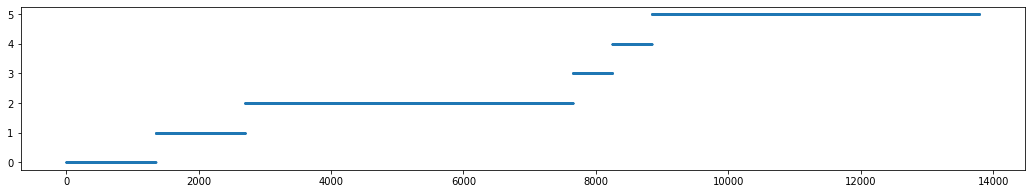

In [ ]:
#show the classes by sample - data is ordered based on original directory
x_val = np.arange(y.shape[0]) #just a list of indices
plt.figure(figsize=(18, 3))
plt.scatter(x_val,y.argmax(axis=1),s=1)
plt.show()
#ACT = ['JOG','JUM','STD','STN','STU','WAL']

#This is the start of the train/test split code

In [ ]:
#split by pre-selected subjects (original load data grouping)
method = "manual split using pre-selected subjects\n"
log_file = log_file + "Split: " + method
split_subj = {'train_subj':[2,4,5,9,10,16,18,20,23,24,26,27,28,32,34,35,
                                36,38,42,45,46,47,48,49,50,51,52,53,54,57],
                   'validation_subj':[3,6,8,11,12,22,37,40,43,56],
                   'test_subj':[7,19,21,25,29,33,39,41,44,55]}

train_index = np.empty([1],dtype=int) #empty list
print("\nTrain Group adding subjects:", end =" ")
for my_sub in split_subj['train_subj']:
    print(my_sub, end =" ")
    #print(np.argwhere(sub == my_sub)[:,0])
    train_index = np.concatenate((train_index, np.argwhere(sub == my_sub)[:,0]))

validation_index = np.empty([1],dtype=int) #empty list
print("\nValidation Group adding subjects:", end =" ")
for my_sub in split_subj['validation_subj']:
    print(my_sub, end =" ")
    validation_index = np.concatenate((validation_index, np.argwhere(sub == my_sub)[:,0]))

test_index = np.empty([1],dtype=int) #empty list
print("\nTrain Group adding subjects:", end =" ")
for my_sub in split_subj['test_subj']:
    print(my_sub, end =" ")
    test_index = np.concatenate((test_index, np.argwhere(sub == my_sub)[:,0]))

print("\n")
#delete first row placeholders
train_index = np.delete(train_index, (0), axis=0) 
validation_index = np.delete(validation_index, (0), axis=0) 
test_index = np.delete(test_index, (0), axis=0)

X_train, X_test, X_validation = X[train_index], X[test_index], X[validation_index]
y_train, y_test, y_validation = y[train_index], y[test_index], y[validation_index]
new_shapes = get_shapes([X_train, y_train, X_validation, y_validation, X_test, y_test])
print (new_shapes)
log_file = log_file + new_shapes


Train Group adding subjects: 2 4 5 9 10 16 18 20 23 24 26 27 28 32 34 35 36 38 42 45 46 47 48 49 50 51 52 53 54 57 
Validation Group adding subjects: 3 6 8 11 12 22 37 40 43 56 
Train Group adding subjects: 7 19 21 25 29 33 39 41 44 55 

X_train shape is (7028, 300, 1) data type is float64
y_train shape is (7028, 6) data type is float64
X_validation shape is (2361, 300, 1) data type is float64
y_validation shape is (2361, 6) data type is float64
X_test shape is (2325, 300, 1) data type is float64
y_test shape is (2325, 6) data type is float64



In [ ]:
#split by subject using sklearn GroupKFold
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html
method = "sklearn GroupKFold(n_splits=10)"
group_kfold = GroupKFold(n_splits=10)
group_kfold.get_n_splits(X, y, sub)
for train_index, test_index in group_kfold.split(X, y, sub):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [ ]:
#Working code to show which subjects went to train, validation, and test
#Uses the index which in the case of GroupKFold is the last fold
#Does not work for stratify since there is no index generated
#TODO:  Output format especially for logging should be improved
#TODO:  Make list to handle 1 - 3 groups (original, train/test, +validate)
unique_elements, counts_elements = np.unique(sub[train_index], return_counts=True)
print("Train group sample count per subject:")
print(np.asarray((unique_elements, counts_elements)))
unique_elements, counts_elements = np.unique(sub[validation_index], return_counts=True)
print("Validation group sample count per subject:")
print(np.asarray((unique_elements, counts_elements)))
unique_elements, counts_elements = np.unique(sub[test_index], return_counts=True)
print("Test group sample count per subject:")
print(np.asarray((unique_elements, counts_elements)))

Train group sample count per subject:
[[  2   4   5   9  10  16  18  20  23  24  26  27  28  32  34  35  36  38
   42  45  46  47  48  49  50  51  52  53  54  57]
 [246 249 250 245 250 236 228 236 236 233 229 229 229 231 229 234 226 236
  237 228 228 232 229 239 230 230 223 242 227 231]]
Validation group sample count per subject:
[[  3   6   8  11  12  22  37  40  43  56]
 [255 229 240 245 240 229 231 230 235 227]]
Test group sample count per subject:
[[  7  19  21  25  29  33  39  41  44  55]
 [247 227 225 234 228 237 231 235 234 227]]


Separation Method: manual split using pre-selected subjects
x/y_train shape  (8274, 15, 1) (8274, 6)
x/y_test shape   (2760, 15, 1) (2760, 6)


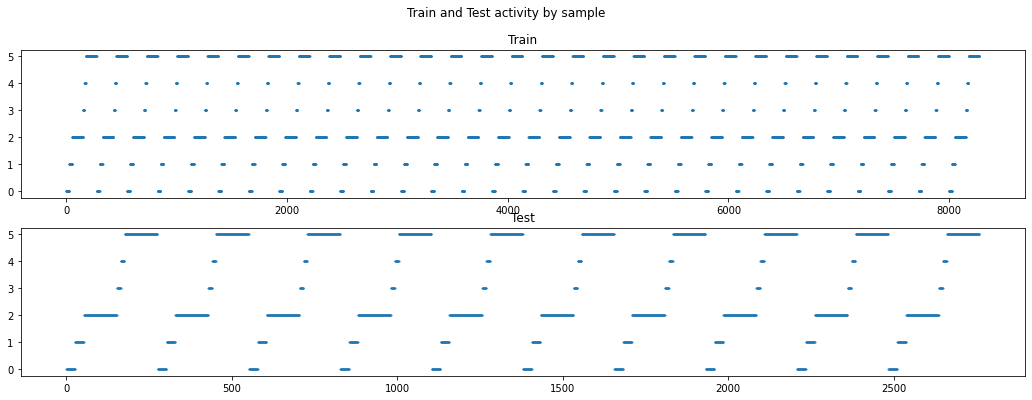

In [ ]:
print("Separation Method:",method)
print("x/y_train shape ",X_train.shape,y_train.shape)
print("x/y_test shape  ",X_test.shape,y_test.shape)
x_val = np.arange(y_train.shape[0]) #just a list of indices
fig, (ax1, ax2) = plt.subplots(2,figsize=(18, 6))
fig.suptitle('Train and Test activity by sample')
# x - list of indices using arange and num rows
# y - argmax to unwind one-hot encoding
# s = 1 sets dot size to smallest
ax1.set_title('Train')
ax1.scatter(np.arange(y_train.shape[0]), y_train.argmax(axis=1),s=1)
ax2.set_title('Test')
ax2.scatter(np.arange(y_test.shape[0]), y_test.argmax(axis=1),s=1)
plt.show()

In [ ]:
#Don't need to rerun the above so log_file stays same after this cell
log_file = log_file + "Rerun of noresample on CPU instance"

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 201, 50)           5050      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 102, 50)           250050    
_________________________________________________________________
dropout_2 (Dropout)          (None, 102, 50)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 51, 50)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2550)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               255100    
_________________________________________________________________
dense_5 (Dense)              (None, 6)                

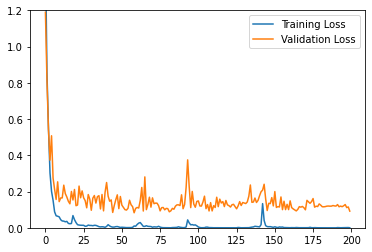

In [ ]:
#Build/evaluate a simple model (also used in load_dataset_demo) topology and good article here
#https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
my_filters = 50
my_kernel_size = 100
BATCH_SIZE = 16
NUM_EPOCHS = 200
config_info = "filters = " + str(my_filters) + " kernel_size = "+ str(my_kernel_size)
config_info = config_info + " BATCH_SIZE = " + str(BATCH_SIZE) + " NUM_EPOCHS = " + str(NUM_EPOCHS)
if (True):
	n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
	model = keras.Sequential(
		[
			keras.Input(shape=(n_timesteps,n_features)),
			layers.Conv1D(filters=my_filters, kernel_size=my_kernel_size, activation='relu'),
			layers.Conv1D(filters=my_filters, kernel_size=my_kernel_size, activation='relu'),
			layers.Dropout(0.5),
			layers.MaxPooling1D(pool_size=2),
			layers.Flatten(),
			layers.Dense(100, activation='relu'),
			layers.Dense(n_outputs, activation='softmax')
   		]
	)
	model.summary()

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
start_time = time.time()

history = model.fit(
        X_train,y_train,
        steps_per_epoch=X_train.shape[1]//BATCH_SIZE,
        epochs=NUM_EPOCHS,
        validation_data=(X_test,y_test),
        validation_steps=X_test.shape[1]//BATCH_SIZE)

end_time = time.time()
train_time = timedelta(seconds=(end_time - start_time))
print(log_file)
print(config_info)
print('Training complete, processing time HH:MM:SS = ',train_time)
cpu_model = !grep 'model name' /proc/cpuinfo
print("CPU(s)", cpu_model)
gpu_info = !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
print("Using GPU",gpu_info[1])
print(method, "\nFinal Validation Accuracy: %0.3f" % history.history['val_accuracy'][-1])
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.ylim([0, 1.2])
plt.legend()
plt.show()

#Older stuff - in parking lot for now

In [ ]:
#Old scratch cell, seems to work so keeping while fixing method
print(type(split_subj))
print(split_subj['test_subj'])
temp_subs = split_subj['test_subj']
temp_index = [] #empty list
for my_sub in split_subj['test_subj']:
    print("Adding subject",my_sub, "indices to test group")
    print(np.argwhere(sub == my_sub)[:,0])
    temp_index = np.concatenate((temp_index, np.argwhere(sub == my_sub)[:,0]))
#print(np.argwhere(sub == 19)[:,0])
#temp_index = np.concatenate([np.argwhere(sub == 7)[:,0]] + [np.argwhere(sub == 19)[:,0]])
print(temp_index)

<class 'dict'>
[7, 19, 21, 25, 29, 33, 39, 41, 44, 55]
Adding subject 7 indices to test group
[ 350  351  352  353  354  410  411  412  413  414  725  726  727  728
  729 1115 1116 1117 1118 1119 1405 1406 1407 1408 1409 1455 1456 1457
 1458 1459 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983
 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025
 2026 2027 2028 2029 2030 4591 4612 4657 4661 4691 4702 4795 4881 4922
 4958 4979 5039 7111 7112 7113 7114 7115 7116 7117 7118 7119 7120 7121
 7122 7123 7124 7125 7126 7127 7128 7129 7130 7131 7132 7133 7134 7135
 7136 7137 7138 7139 7140 7141 7142 7143 7144 7145 7146 7147 7148 7149
 7150 7151 7152 7153 7154 7155 7156 7157 7158 7159 7160 7161 7162 7163
 7164 7165 7166 7167 7168 7169]
Adding subject 19 indices to test group
[  65   66   67   68   69  160  161  162  163  164  3